In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\angon\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Conducción de calor en una placa plana 1D. 

Uno de los problemas más simples que se puede modelar es la distribución de temperatura en una placa plana. Este sistema está gobernado por la ecuación de calor en 1D:

$$ -k\frac{d^2T}{dx^2} - q = 0 $$

En esta ecuación $k$ es la conductividad térmica, $T$ la temperatura, $x$ la posición espacial y $q$ la tasa de generación de calor en el material.  

Esta ecuación es muy simple de solucionar de manera analítica. Sin embargo, a manera de ejemplo implementaremos un algoritmo para la solución de esta solución mediante el método de los elementos finitos.  

Para completar la definición del problema se establece el dominio del mismo para $0 < x < L$ con una condición de frontera esencial en $x=0$

$T(0) = g \\textrm{ - condición esencial}$  
$\frac{dT(L)}{dx} = h \\textrm{ - condición natural}$  




In [127]:
def basis(xbar,i,he):
    """Returns the ith basis funciton at x
    xbar - local element coordinate
    i - basis function index
    he - width of each element
    """
    if i == 0: return 1 - xbar/he
    if i == 1: return xbar/he
    return -1 # Este seria un codigo de error, toca mejorar

def dbasis(x,i,he):
    """Returns the ith basis funciton at x
    xbar - local element coordinate
    i - basis funciton index
    he - width of each element
    """
    if i == 0: return -1/he
    if i == 1: return 1/he
    return -1 # Este seria un codigo de error, toca mejorar

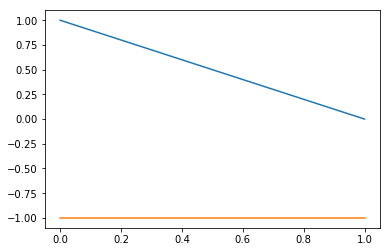

In [128]:
# Verifiquemos si sí se está devolviendo bien la función de forma
xvec = linspace(0,1,10)
basisv = vectorize(basis)
plot(xvec,basisv(xvec,0,1))
dbasisv = vectorize(dbasis)
plot(xvec,dbasisv(xvec,0,1))

In [129]:
def f(x):
    return 1.0

In [130]:
L = 1.0
n = 4
dx = L/n
dofpe = 2 # Grados de libertad por elemento, por ahora solo programado 2
g = 1.0 # u(0) = g
h = 0.0 # u'(1) = h

In [131]:
coords = linspace(0,L,n+1)
elementos = zeros((n,2),dtype=int)
for i in range(n):
    elementos[i,0] = int(i)
    elementos[i,1] = int(i+1)

In [132]:
K = np.zeros((n+1,n+1))

# Aqui vamos a hacer la integracion sobre cada elemento
# Ojo que estoy haciendo una integral super basica con el 
# punto medio
for e in range(n): # loop over elements
    dx = coords[elementos[e,1]] - coords[elementos[e,0]]
    for i in range(dofpe): # loop over basis i
        for j in range(dofpe): # loop over basis j
            xmid = 0.5*dx
            dNi = dbasis(xmid,i,dx)
            dNj = dbasis(xmid,j,dx)
            K[elementos[e,i],elementos[e,j]] += dNi*dNj*dx


In [133]:
F = np.zeros((n+1))
for e in range(n):
    dx = coords[elementos[e,1]] - coords[elementos[e,0]]
    for i in range(dofpe):
        xmid = 0.5*dx
        Ni = basis(xmid,i,dx)
        F[elementos[e,i]] += Ni*f(xmid)*dx

In [134]:
# Adjust for Dirichlet condition
ibc = 0
F -= K[:,ibc]*g
K[:,ibc] = K[ibc,:] = 0
K[ibc,ibc] = 1
F[ibc] = g

# Add Neumann condition
F[n] += h

In [136]:
# Solve
d = np.linalg.solve(K,F)

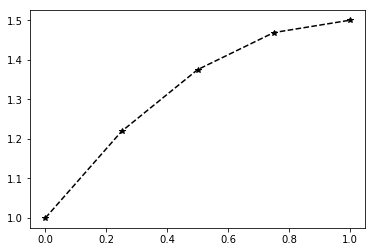

In [138]:
# Una grafica sencilla de los valores de la temp. en los nodos
plot(coords,d,'--*k')

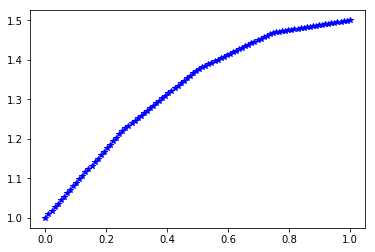

In [162]:
# Ahora vamos a graficar valores interpolando entre nodos.
x = np.linspace(0,L,100)
temp = zeros(size(x))
for i,coord in enumerate(x):
    if coord == 0:
        temp[i] = d[i]
        continue
    elem = np.where((coords<coord))[0][-1]
    for j in range(dofpe):
        x1 = coords[elementos[elem,0]]
        dx = coords[elementos[elem,1]] - x1
        xbar = coord-x1
        temp[i] += basis(xbar,j,dx)*d[elementos[elem,j]]
plot(x,temp,'b*')


